In [54]:
import numpy as np
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
from scipy.special import expit
from queue import Queue
import time

from src.sensor_utils import *
from src.interfaces import *
from src.grid_utils import *
from src.coordinates import *
from src.navigation import *
from src.mapping_utils import get_perceptual_field
from IPython.display import clear_output 

In [55]:
# Connect to the Coppeliasim API
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(False)

0

In [56]:
"""
Gets informations from API.
"""

robot_path = '/kobuki'
sensor_path = robot_path + '/fastHokuyo'
robot_handle = sim.getObject(robot_path)
rmotor = sim.getObject(robot_path + '/kobuki_rightMotor')
lmotor = sim.getObject(robot_path + '/kobuki_leftMotor')
sensor_handle = sim.getObject(robot_path + '/fastHokuyo')
rmotor_handle = sim.getObject(robot_path + '/kobuki_rightMotor')
lmotor_handle = sim.getObject(robot_path + '/kobuki_leftMotor')

In [57]:
"""
Defines variables for executing the Occupancy Grid algorithm.
"""

# In meters
map_size = 10 
cell_size = .05

grid_size = int(np.ceil(map_size / cell_size))

l_0 = 0 # log(0.5/0.5) = 0
l_prev = np.zeros((grid_size, grid_size))
l_occ = np.log(0.65/(1 - 0.65))
l_free = np.log(0.35/(1 - 0.35))

zmax = 5
zmax *= 0.9999

alpha = .1
beta = .05


***Algorithm***: occupancy_grid_mapping($l(t-1)$, $x_t$, $z_t$)

**for** all cells $m_i$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;**if** $m_i$ is in the perceptual field of $z_t$ **then**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$l_{t,i} \gets l_{t-1,i} + \text{inverse\_sensor\_model}(m_i, x_t, z_t) - l_0$

&nbsp;&nbsp;&nbsp;&nbsp;**else**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$l_{t,i} \gets l_{t-1,i}$

&nbsp;&nbsp;&nbsp;&nbsp;**end if**

**end for**

**return** $l_t$

This algorithm determines cell occupancy within the sensor's perceptual field (i.e., its cone of vision) by first identifying all cells falling within this area. Then, for each identified cell, it determines the sensor ray that best represents it (i.e., the ray most directly intersecting or passing closest to the cell's center) and calculates the cell's occupancy probability based on the sensor reading data associated with that specific ray.

- Occluding the underscored $t$ in variables.
- $z$ is the list of observations (one by ray) seeing during the observation and $m$ as the coordinates of each cell in the occupancy grid.
- $sens\_theta$ is the orientation of each ray in relation to the robot frame.
- $\alpha$ is the thickness of the obstacle and is assumed regardless of the true value.
- $r$ is the distance between the sensor and the cell.
- $x$ is the current pose of the robot.
- $k$ is the index of the sensor better aligned with the cell.

In [58]:
"""
Occupancy Grid Algorithm
"""


def occupancy_grid_mapping(
    l_prev: np.ndarray[np.float64],
    perceptual_field: set,
    x: Pose,
    z: list,
    sens_theta: list,
    grid_size: int,
    cell_size: float,
) -> np.ndarray:
    """
    Updates the occupancy grid based on the current sensor readings.

    Args:
        l_prev (np.ndarray): The previous occupancy grid.
        perceptual_field (set): The set of cells in the perceptual field of the robot.
        x (Pose): The current pose of the robot.
        z (list): The current sensor readings.
        sens_theta (list): The angles of the sensors.
        grid_size (int): The size of the grid.
        cell_size (float): The size of each cell in the grid.

    Returns:
        np.ndarray: The updated occupancy grid.
    """
    l = np.copy(l_prev)
    for mi in perceptual_field:
        # Calculate the new log-odds value for the cell
        l[mi] = (
            l_prev[mi]
            + inverse_range_sensor_model(mi, x, z, sens_theta, grid_size, cell_size)
            - l_0
        )
    return l


def inverse_range_sensor_model(
    mi: tuple[int, int],
    pose: Pose,
    z: list,
    sens_theta: list,
    grid_size: int,
    cell_size: float,
) -> int:
    """
    Calculates the inverse range sensor model for a cell.

    Args:
        mi (tuple): The indices of the cell.
        pose (Pose): The current pose of the robot.
        z (list): The current sensor readings.
        sens_theta (list): The angles of the sensors.
        grid_size (int): The size of the grid.
        cell_size (float): The size of each cell in the grid.

    Returns:
        int: The log-odds value for the cell.
    """
    # Convert the cell index to a point in the grid
    i = get_point_from_idx(Point(mi[1], mi[0]), grid_size, cell_size)

    # Calculate the distance and angle from the robot to the cell
    r = np.sqrt((i.x - pose.x) ** 2 + (i.y - pose.y) ** 2)
    phi = np.arctan2(i.y - pose.y, i.x - pose.x) - pose.theta

    # Find the closest sensor reading to the angle
    k = np.argmin(np.abs(phi - sens_theta))

    # Determine the log-odds value based on the sensor reading
    if r > min(zmax, z[k] + alpha) or abs(phi - sens_theta[k]) > beta:
        return l_0
    elif z[k] < zmax and np.abs(r - z[k]) <= alpha:
        return l_occ
    elif r <= z[k]:
        return l_free
    return l_0

### Line Detection Demo

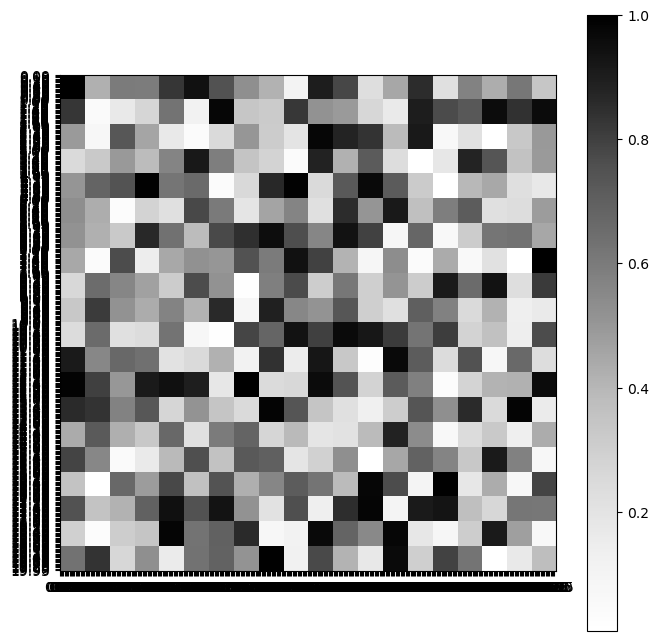

In [59]:
"""
Plots a random map.
"""

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

m_size = np.array([20, 20])
c_size = 1

rows, cols = (m_size/c_size).astype(int)

m = np.random.uniform(low=0.0, high=1.0, size=(rows, cols))

m[0,0] = 1 
plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))

ax.set_xticks(np.arange(0, cols, cell_size))
ax.set_yticks(np.arange(0, rows, cell_size))

plt.colorbar()

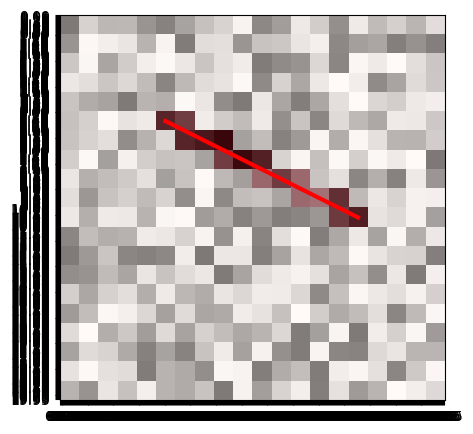

In [60]:
"""
Shows line detection algorithm working.
"""

x, y = 5.5, 5.5
xo, yo = 15.5, 10.5

line_bresenham = np.zeros((rows, cols), dtype=np.uint8)
aa = cells_on_line(Point(y, x), Point(yo, xo), m_size[0], c_size, False)
for row, col in aa:
    line_bresenham[row, col] = 1

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.imshow(m, cmap='Greys', extent=(0, cols, rows, 0))
ax.imshow(line_bresenham, cmap='Reds', extent=(0, cols, rows, 0), alpha=.5)

ax.set_xticks(np.arange(0, cols, cell_size))
ax.set_yticks(np.arange(0, rows, cell_size))

ax.plot([x, xo], [y, yo], 'r-', linewidth=3)

### Execution

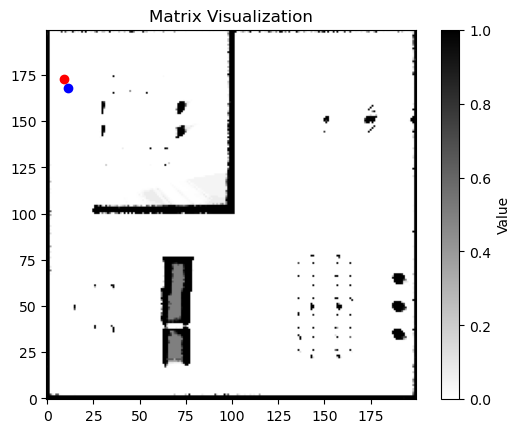

In [67]:
# Start simulation
sim.startSimulation()
sim.setJointTargetVelocity(rmotor_handle, 0)
sim.setJointTargetVelocity(lmotor_handle, 0)

l_prev = np.zeros((grid_size, grid_size))
probs = expit(l_prev)

start_turn_time = time.time()
turn = True

path = Queue()
for point in [(0.35, -4.5), (0.30, -1.325), (2.8, 0.875), (1.25, -0.65), (-0.675, -0.6), (-4.3, -0.475), (-4.3, 1.275), (-4.5, 3.675)]:
    path.put(point)

# Generate a random index for the row
pprev = sim.getObjectPosition(robot_handle)
pprev = np.array(pprev[:2])
pgoal = np.copy(pprev)
_, _, oprev = sim.getObjectOrientation(robot_handle)

while True:
    # Get robot pose
    *pcurr, _ = sim.getObjectPosition(robot_handle)
    pcurr = np.array(pcurr[:2])
    _, _, ocurr = sim.getObjectOrientation(robot_handle)

    robot_pose = Pose(pcurr[0], pcurr[1], ocurr)
    robot_position = Point(robot_pose.x, robot_pose.y)
    ray_origin = get_cell_idx(robot_position, grid_size, cell_size)

    sensor_data = get_sensor_data(sim)
    sensor_data[:, 1] = [i + np.random.uniform(0, cell_size*3) for i in sensor_data[:, 1]]

    W_LT = calculate_object_transformation(sensor_handle, sim.handle_world, sim)
    global_laser_points, local_laser_points = handle_laser_data(sensor_data, W_LT, max_sensor_range=zmax)

    perceptual_field = get_perceptual_field(global_laser_points, robot_position, grid_size, cell_size)

    l_prev = occupancy_grid_mapping(l_prev, perceptual_field, robot_pose, sensor_data[:, 1], sensor_data[:, 0],
                                    grid_size, cell_size)
    probs = expit(l_prev)

    # Robot is turning 
    if turn:
        turn_time = time.time() - start_turn_time    

        # If the robot has not made a full 360º turn yet, keep turning
        if np.abs(ocurr - oprev) > 0.5 or turn_time < 1:
            set_velocity(sim, rmotor, 5, lmotor, 0)
        # Else set a goal point and start moving
        else:
            set_velocity(sim, rmotor, 0, lmotor, 0)

            if path.empty(): break

            pgoal = path.get()
            turn = False

    # Robot is moving
    else:
        dx, dy = pgoal - pcurr
        distance_to_goal = np.sqrt(dx**2 + dy**2)
        distance_traveled = np.linalg.norm(pprev - pcurr)
        
        # If the robot got to the goal, make a 360º turn
        if distance_to_goal < .2:
            set_velocity(sim, rmotor, 0, lmotor, 0)
            _, _, oprev = sim.getObjectOrientation(robot_handle)
            start_turn_time = time.time()
            turn = True

        # Else keep pathing towards the goal
        else:
            walk(pcurr, ocurr, pgoal, sim, rmotor, lmotor, sensor_handle)

    plt.clf()
    clear_output()
    goal_idx = get_cell_idx(Point(pgoal[0], pgoal[1]), grid_size, cell_size)
    plt.imshow(probs, cmap='gray_r', vmin=0, vmax=1, origin='lower')
    plt.plot(goal_idx.x, goal_idx.y, 'ro')  # Plot robot position
    plt.plot(ray_origin.x, ray_origin.y, 'bo')  # Plot robot position
    plt.colorbar(label='Value')
    plt.title('Matrix Visualization')
    plt.show()
plt.show()

sim.setJointTargetVelocity(rmotor_handle, 0)
sim.setJointTargetVelocity(lmotor_handle, 0)
sim.stopSimulation()

### Appendix: Incremental Plot

In [62]:
def plot_incremental_laser_detection(laser_data_history, W_RT_history, 
                                     laser_points_history, max_sensor_range=5,
                                     savefig=False, filename='plot.png'):

    fig, ax = plt.subplots(figsize=(6,6), dpi=100)
    
    for laser_data, laser_points in zip(laser_data_history, laser_points_history):
        for i in range(len(laser_data)):
            ang, dist = laser_data[i]
            # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
            # Logo, usar um pequeno limiar do máximo para considerar a leitura
            if (max_sensor_range - dist) > 0.1:
                ax.plot(*laser_points[i, :2], 'o', color='black')
    
    # Desenha a localização do robô no plano
    for W_RT in W_RT_history:
        ax.plot(*W_RT[:2, 3], marker='*', markersize=10, color='red')
    
        # Adiciona uma seta para representar a orientação do robô
        robot_orientation = np.arctan2(W_RT[1, 0], W_RT[0, 0])
        arrow_length = 0.4
        dx = arrow_length * np.cos(robot_orientation)
        dy = arrow_length * np.sin(robot_orientation)
        ax.arrow(*W_RT[:2, 3], dx, dy, color='red', head_width=0.2, head_length=0.3)
    
    ax.axis('scaled')
    ax.axis((-5, 5, -5, 5))
    ax.grid()
    
    if savefig:
        plt.savefig(filename)

    plt.show()

In [63]:
# Start simulation
sim.startSimulation()
sim.setJointTargetVelocity(rmotor_handle, 0)
sim.setJointTargetVelocity(lmotor_handle, 0)

l_prev = np.zeros((grid_size, grid_size))
probs = expit(l_prev)

start_turn_time = time.time()
turn = True

path = Queue()
for point in [(0.35, -4.5), (0.30, -1.325), (2.8, 0.875), (1.25, -0.65), (-4.3, -0.475), (-4.3, 1.275), (-4.325, 3.675)]:
    path.put(point)

# Generate a random index for the row
pprev = sim.getObjectPosition(robot_handle)
pprev = np.array(pprev[:2])
pgoal = np.copy(pprev)
_, _, oprev = sim.getObjectOrientation(robot_handle)

sensorss = []
sensor_grid = np.zeros((grid_size, grid_size))

laser_data_history = []
pose_history = []
gpoints_history = []

i = 0
while True:
    i += 1
    p_field = set()

    # Get robot pose
    *pcurr, _ = sim.getObjectPosition(robot_handle)
    pcurr = np.array(pcurr[:2])
    _, _, ocurr = sim.getObjectOrientation(robot_handle)
    robot_pose = Pose(pcurr[0], pcurr[1], ocurr)
    robot_position = Point(robot_pose.x, robot_pose.y)
    ray_origin = get_cell_idx(robot_position, grid_size, cell_size)

    # Get sensor data
    sensor_data = get_sensor_data(sim)
    laser_data_history.append(sensor_data)

    W_RT, W_LT = global_references([robot_path, sensor_path], sim)
    pose_history.append(W_RT)

    # Get the position and orientation of the laser in relation to the global coordinates
    W_LT = calculate_object_transformation(sensor_handle, sim.handle_world, sim)
    global_laser_points, _ = handle_laser_data(sensor_data, W_LT, max_sensor_range=zmax)
    gpoints_history.append(global_laser_points)

    # Find the perceptual field
    for i in range(len(global_laser_points)):
        ang, dist = sensor_data[i]
            
        ray_detection_global = Point(global_laser_points[i][0], global_laser_points[i][1])
        ray_path = cells_on_line(robot_position, ray_detection_global, grid_size, cell_size)

        for col, row in ray_path:
            if 0 <= col < grid_size and 0 <= row < grid_size:
                p_field.add((row, col))

    # Update probabilities
    l_prev = occupancy_grid_mapping(l_prev, p_field, robot_pose, sensor_data[:, 1], sensor_data[:, 0],
                                    grid_size, cell_size)
    probs = expit(l_prev)

    # Robot is turning 
    if turn:
        turn_time = time.time() - start_turn_time    

        # If the robot has not made a full 360º turn yet, keep turning
        if np.abs(ocurr - oprev) > 1. or turn_time < 2:
            set_velocity(sim, rmotor, 3, lmotor, 0)
        # Else start moving the robot
        else:
            set_velocity(sim, rmotor, 0, lmotor, 0)

            if path.empty(): break

            pgoal = path.get()
            turn = False

    # Robot is moving
    else:
        dx, dy = pgoal - pcurr
        distance_to_goal = np.sqrt(dx**2 + dy**2)
        distance_traveled = np.linalg.norm(pprev - pcurr)
        
        # If the robot got to the goal, make a 360º turn
        if distance_to_goal < .2:
            set_velocity(sim, rmotor, 0, lmotor, 0)
            _, _, oprev = sim.getObjectOrientation(robot_handle)
            start_turn_time = time.time()
            turn = True

        # Else keep pathing towards the goal
        else:
            walk(pcurr, ocurr, pgoal, sim, rmotor, lmotor, sensor_handle)

sim.setJointTargetVelocity(rmotor_handle, 0)
sim.setJointTargetVelocity(lmotor_handle, 0)
sim.stopSimulation()

plot_incremental_laser_detection(laser_data_history, pose_history[::10], gpoints_history)

KeyboardInterrupt: 

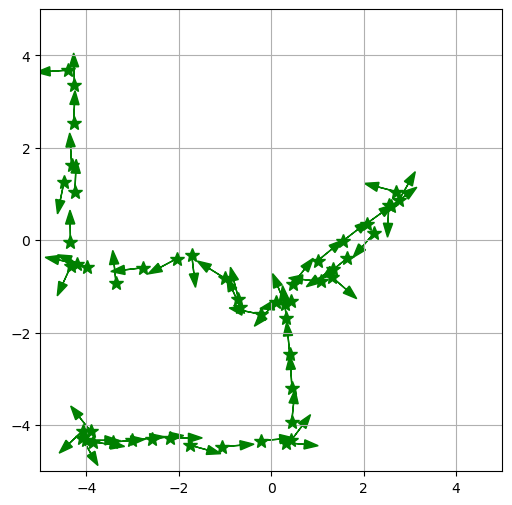

In [ ]:
plot_incremental_laser_detection(laser_data_history, pose_history[::10], gpoints_history)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), dpi=100)

for x, y in sensorss:
    i = get_point_from_idx(Point(x, y), grid_size, cell_size)
    ax.plot(x, y, 'o', color='black')

# Plot the sensor grid
ax.axis('scaled')
ax.axis((-5, 5, -5, 5))
ax.grid()
plt.show()